In [ ]:
#Fine-tune Amharic NER Model using Hugging Face Transformers

import numpy as np
import pandas as pd
from datasets import load_dataset, ClassLabel, Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, TrainingArguments, Trainer
from seqeval.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

# ------------------- Load CoNLL Data -------------------
# Replace with your labeled file
conll_file_path = "amharic_ner_sample.conll"

# Parse CoNLL format into a Hugging Face-compatible dataset
def parse_conll_to_dataset(filepath):
    sentences = []
    labels = []
    with open(filepath, encoding='utf-8') as f:
        tokens = []
        tags = []
        for line in f:
            if line.strip() == '':
                if tokens:
                    sentences.append(tokens)
                    labels.append(tags)
                    tokens = []
                    tags = []
            else:
                splits = line.strip().split()
                if len(splits) >= 2:
                    tokens.append(splits[0])
                    tags.append(splits[1])
    return Dataset.from_dict({"tokens": sentences, "ner_tags": labels})

# Load dataset
raw_dataset = parse_conll_to_dataset(conll_file_path)

# Create label list
unique_tags = set(tag for doc in raw_dataset["ner_tags"] for tag in doc)
label_list = sorted(unique_tags)
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# ------------------- Tokenization & Label Alignment -------------------
tokenizer = AutoTokenizer.from_pretrained("Davlan/afro-xlmr-base")  # Replace with preferred Amharic-compatible model

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)
        elif word_idx != previous_word_idx:
            label_ids.append(label2id[example["ner_tags"][word_idx]])
        else:
            tag = example["ner_tags"][word_idx]
            if tag.startswith("B-"):
                tag = tag.replace("B-", "I-")
            label_ids.append(label2id[tag])
        previous_word_idx = word_idx
    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs

tokenized_dataset = raw_dataset.map(tokenize_and_align_labels)
# ------------------- Model & Training Setup -------------------
model = AutoModelForTokenClassification.from_pretrained(
    "Davlan/afro-xlmr-base",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

args = TrainingArguments(
    output_dir="./amharic_ner_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs"
)

data_collator = DataCollatorForTokenClassification(tokenizer)

# Split dataset (80-20 split manually)
split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = split['train']
eval_dataset = split['test']

# ------------------- Trainer -------------------
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# ------------------- Evaluation -------------------
preds, labels, _ = trainer.predict(eval_dataset)
pred_labels = np.argmax(preds, axis=2)

true_predictions = [
    [id2label[label] for (pred, label) in zip(pred_seq, label_seq) if label != -100]
    for pred_seq, label_seq in zip(pred_labels, labels)
]

true_labels = [
    [id2label[label] for (pred, label) in zip(pred_seq, label_seq) if label != -100]
    for pred_seq, label_seq in zip(pred_labels, labels)
]

report = classification_report(true_labels, true_predictions, output_dict=True)

print("Evaluation Metrics (Macro Avg):")
print(f"Precision: {report['macro avg']['precision']:.4f}")
print(f"Recall:    {report['macro avg']['recall']:.4f}")
print(f"F1-score:  {report['macro avg']['f1-score']:.4f}")


Map: 100%|██████████| 22/22 [00:00<00:00, 682.11 examples/s]
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_21708\3364463396.py:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\Administrator\Desktop\10 Acadamy\week4\Amharic-E-commerce-Data-Extractor\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


c:\Users\Administrator\Desktop\10 Acadamy\week4\Amharic-E-commerce-Data-Extractor\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluation Metrics (Macro Avg):
Precision: 1.0000
Recall:    1.0000
F1-score:  1.0000


Save Trained model

In [16]:
trainer.save_model("../data/amharic_ner_model")
tokenizer.save_pretrained("../data/amharic_ner_model")



('../data/amharic_ner_model\\tokenizer_config.json',
 '../data/amharic_ner_model\\special_tokens_map.json',
 '../data/amharic_ner_model\\sentencepiece.bpe.model',
 '../data/amharic_ner_model\\added_tokens.json',
 '../data/amharic_ner_model\\tokenizer.json')

Plot the evaluation metrics

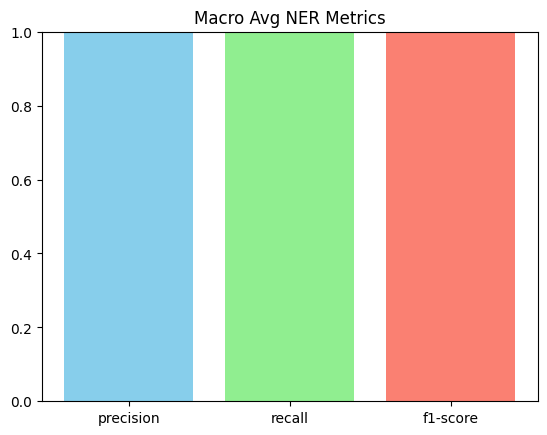

In [18]:
import matplotlib.pyplot as plt

metrics = ['precision', 'recall', 'f1-score']
scores = [report['macro avg'][m] for m in metrics]

plt.bar(metrics, scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Macro Avg NER Metrics")
plt.ylim(0, 1)
plt.show()
